## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Нам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес-процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представим, что мы заказываем такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько мы должны будем за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда мы едете, в какое время суток мы совершаем нашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта мы отработаем навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import sqrt, exp

from scipy import stats
from scipy.stats import normaltest

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn import cluster
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [10]:
taxi_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделим признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


###Базовый анализ
Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Временные характестики
Посмотрим на временные рамки, в которых мы работаем с данными.
Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [11]:
taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

*Поездки производились в период с 1 января по 30 июня 2016 года*

### Пропуски
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [12]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

*Пропусков не обнаружено*

### Статистические характеристики
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [13]:
taxi_data.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


*В признаке 'trip_duration' есть аномалии. В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.*

In [14]:
#cколько уникальных таксопарков присутствует в данных
num_taxiparks = len(taxi_data['vendor_id'].unique())
print(f"В данных присутствует информация о {num_taxiparks} таксопарках")

В данных присутствует информация о 2 таксопарках


In [15]:
#каково максимальное количество пассажиров
num_passengers = taxi_data['passenger_count'].max()
print(f"Максимальное количество пассажиров {num_passengers} человек")

Максимальное количество пассажиров 9 человек


In [16]:
min_trip_duration = taxi_data['trip_duration'].min().round()
max_trip_duration = taxi_data['trip_duration'].max().round()

print(f"Минимальное время поездки {min_trip_duration} секунда")
print(f"Максимальное время поездки {max_trip_duration} секунд")

Минимальное время поездки 1 секунда
Максимальное время поездки 3526282 секунд


###Добавление признаков
Расширим исходный набор данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 



Начнём с временных характеристик. Как нам уже известно, хранить дату и время в формате datetime как категориальный признак редко имеет смысл, поэтому мы их разобъем на отдельные признаки. Эти признаки могут как стать основными факторами при построении модели, так и быть вспомогательными для извлечения информации из других таблиц.

In [17]:
def add_datetime_features(data):
  """Добавление в таблицу 3-х дополнительных столбцов:
            pickup_date - дата включения счетчика - начала поездки (без времени);
            pickup_hour - час дня включения счетчика;
            pickup_day_of_week - наименование дня недели, в который был включен счетчик.

   Args:
      data (DataFrame):Таблица с данными о поездках

   Returns:
      DataFrame: таблица с добавленными столбцами.
  """
  data['pickup_date'] = data['pickup_datetime'].dt.date
  data['pickup_hour'] = data['pickup_datetime'].dt.hour
  data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek
  return data

Применим созданную функцию к нашей базе данных и определим количество поездок в субботу и среднее количество поездок в день.

In [18]:
taxi_data = add_datetime_features(taxi_data)
sat_count = taxi_data['pickup_day_of_week'].value_counts()[5]
print(f'Количество поездок в субботу: {sat_count}')
mean_trip = taxi_data['pickup_date'].value_counts().mean().round(0).astype(np.int16)
print(f'Среднее количество поездок в день: {mean_trip}')

Количество поездок в субботу: 220868
Среднее количество поездок в день: 8015


In [19]:
#загрузим базу данных с праздничными и выходными днями
holiday_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/holiday_data.csv', sep=';')

От того, является ли день праздничным, часто зависит ситуация на дорогах.   Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

Добавим в наш датасет информацию о том, является ли день праздничным. 
Для этого мы собрали даты всех праздничных дней в Америке за 2016 год. 
Данные представлены в табличном формате CSV и содержат три столбца:

day — день недели;
date — дата;
holiday — наименование праздника.

В 2016 году в США было 15 праздничных дней, список которых вы можете видеть ниже:



In [20]:
list_holiday = holiday_data[['date','holiday']]
print(f"В 2016 году в США было 15 праздничных дней: \n{list_holiday}")

В 2016 году в США было 15 праздничных дней: 
          date                     holiday
0   2016-01-01               New Years Day
1   2016-01-18  Martin Luther King Jr. Day
2   2016-02-12          Lincoln's Birthday
3   2016-02-15             Presidents' Day
4   2016-05-08                Mother's Day
5   2016-05-30                Memorial Day
6   2016-06-19                Father's Day
7   2016-07-04            Independence Day
8   2016-09-05                   Labor Day
9   2016-10-10                Columbus Day
10  2016-11-11                Veterans Day
11  2016-11-24                Thanksgiving
12  2016-12-26     Christmas Day (in lieu)
13  2016-07-04            Independence Day
14  2016-11-08                Election Day


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [21]:
def add_holiday_features(trip_data,holidays_data):
  """Добавляет в таблицу с данными о поездках  столбец с бинарным признаком, 
  начата ли поездка в праздничный день или нет

  Args:
      trip_data (DataFrame): таблица с данными о поездках
      holidays_data (DataFrame): таблица с данными о праздничных днях

  Returns:
      DataFrame:Обновленная таблица с данными о поездках с добавленным в нее столбцом pickup_holiday - 
      бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).
  """
  holidays_data['date'] = pd.to_datetime(holidays_data['date'], format='%Y-%m-%d %H:%M:%S')
  holidays_data['date'] = holidays_data['date'].dt.date
  trip_data['pickup_holiday'] = trip_data['pickup_date'].apply(lambda x: 1 if x in holidays_data['date'].values else 0)
  return trip_data

Применим полученную функцию к таблице, посмотрим на соотношение обычных и праздничных дней.

In [22]:
taxi_data = add_holiday_features(taxi_data,holiday_data)
taxi_data['pickup_holiday'].value_counts(normalize = True).round(2)*100

0    96.0
1     4.0
Name: pickup_holiday, dtype: float64

*На долю праздничных дней пришлось 4% поездок, остальные 96% поездок пришлись на будние дни.   
Соотношение праздничных и обычных дней в году также 4% на 96% соответственно (350 и 15 дней).   
Это говорит о том, что активность в целом, в будние и праздничные дни одинакова.*


Найдём медианную длительность поездки на такси в праздничные дни в секундах.

In [23]:
mask = taxi_data['pickup_holiday'] == 1
median_dataframe = taxi_data[mask]['trip_duration'].median().round().astype(int)
print(f"Медианная длительность поездки на такси в праздничные дни составляет {median_dataframe} секунд")

Медианная длительность поездки на такси в праздничные дни составляет 585 секунд


### Географические характеристики
Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API.

OSRM (Open Source Routing Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута.  
 Он позволяет не только построить оптимальный кусочно-линейный путь из точки А в точку B, но также узнать его примерную длительность, длину, а также подробную информацию о количестве шагов, которые необходимо преодолеть по пути (количество поворотов).   
У данного сервиса есть API, из которого уже взята информация в файле osrm_data_train.zip в табличном формате CSV

Нас будут интересовать только следующие столбцы:

id — идентификатор поездки;
total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

In [24]:
osrm_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/osrm_data_train.zip')


Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [25]:
def add_osrm_features(trip_data,data_osrm):
  """Добавляет в таблицу столбцы с дополнительными географическими данными
  Args:
      trip_data (DataFrame): таблица с данными о поездках
      data_osrm (DataFrame): таблица с данными из OSRM

  Returns:
      DataFrame: Обновленная таблицу с данными о поездках с добавленными в нее 3 столбцами:
      total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
      total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM); 
      number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).
  """
  data_osrm = data_osrm[['id','total_distance','total_travel_time','number_of_steps']]
  merged_data = trip_data.merge(
    data_osrm,
    on='id',
    how='left'
  )
  return merged_data

Применим данную функцию к нашим данным и определим чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 



In [26]:
taxi_data = add_osrm_features(taxi_data,osrm_data)
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [27]:
time_delta = taxi_data['trip_duration'].median().round() - taxi_data['total_travel_time'].median().round()
print(f"Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM: {time_delta.astype(int)} секунды")

Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM: 372 секунды


Эта цифра отражает то, что время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, так как оно вычисляется по кратчайшему пути при идеальных условиях: отсутствие пробок, погодных влияний и других внешних факторов. 

В результате объединения таблиц у нас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

Определим сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [28]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

*Пропуски обнаружены в признаках total_distance, total_travel_time, number_of_steps*

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Введём в наш анализ расстояние по формуле Хаверсина. 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

In [29]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    """функция для вычисления расстояния Хаверсина (в километрах)

    Args:
        lat1 (float): широта места начала движения
        lng1 (float): долгота места начала движения
        lat2 (float): широта места окончания движения
        lng2 (float): долгота места окончания движения

    Returns:
        float: Кратчайшее расстояние между двумя точками на сфере
    """
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    """Функция для вычисления угла направления движения (в градусах).

    Args:
        lat1 (float): широта места начала движения
        lng1 (float): долгота места начала движения
        lat2 (float): широта места окончания движения
        lng2 (float): долгота места окончания движения

    Returns:
        float: Угол направления движения alpha по формуле угла пеленга
    """
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [30]:
def add_geographical_features(data_trip):
  """Функция добавляет в таблицу столбцы с расстоянием Хаверсина и направлением движения

  Args:
      data_trip (DataFrame): Таблица с данными о поездках 

  Returns:
      DataFrame: Обновленная таблица с добавленными столбцами
  """
  data_trip['haversine_distance', 'direction'] = 0
  for i in range(0,len(data_trip)):
    lat1 = data_trip.loc[i,'pickup_latitude']
    lng1 = data_trip.loc[i,'pickup_longitude']
    lat2 = data_trip.loc[i,'dropoff_latitude']
    lng2 = data_trip.loc[i,'dropoff_longitude']
    data_trip.loc[i,'haversine_distance'] = get_haversine_distance(lat1, lng1, lat2 , lng2)
    data_trip.loc[i,'direction'] = get_angle_direction(lat1, lng1, lat2 , lng2)
  return data_trip    

Применим созданную функцию к нашему датасету

In [31]:
#taxi_data = add_geographical_features(taxi_data)

In [32]:
#pd.DataFrame(taxi_data).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/taxi_data_distance.csv', sep = ',', index = False)

In [33]:
taxi_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/taxi_data_distance.csv')


Чему равно медианное расстояние Хаверсина поездок (в километрах)? 

In [34]:
print('Медианное расстояние Хаверсина: {:.2f} км.'.format(taxi_data['haversine_distance'].median()))

Медианное расстояние Хаверсина: 2.09 км.


In [35]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1458644 non-null  object 
 1   vendor_id                            1458644 non-null  int64  
 2   pickup_datetime                      1458644 non-null  object 
 3   dropoff_datetime                     1458644 non-null  object 
 4   passenger_count                      1458644 non-null  int64  
 5   pickup_longitude                     1458644 non-null  float64
 6   pickup_latitude                      1458644 non-null  float64
 7   dropoff_longitude                    1458644 non-null  float64
 8   dropoff_latitude                     1458644 non-null  float64
 9   store_and_fwd_flag                   1458644 non-null  object 
 10  trip_duration                        1458644 non-null  int64  
 11

In [36]:
#удалим лишний столбец
taxi_data.drop(taxi_data.columns[[18]], axis = 1, inplace = True)

### Кластеризация географических данных
Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам.   
Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

→ Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means.  
Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.


In [37]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации.   
Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [38]:
def add_cluster_features(data_trip, kmeans):
  """Функция добавляет в таблицу столбец с географическим кластером
  Args:
      data_trip (DataFrame):Исходный датасет
      kmeans (model): Обученный алгоритм кластеризации

  Returns:
      DataFrame: Обновленная таблица с добавленными в нее столбцом 
     geo_cluster - географический кластер, к которому относится поездка.
  """
  coords = np.hstack((data_trip[['pickup_latitude', 'pickup_longitude']],
                    data_trip[['dropoff_latitude', 'dropoff_longitude']]))
  data_pred = kmeans.predict(coords)
  data_trip['geo_cluster'] = data_pred
  return data_trip  

Применим созданную функцию к рабочему датафрейму и ответим на вопрос:  
Сколько поездок содержится в наименьшем по размеру географическом кластере?

In [39]:
taxi_data = add_cluster_features(taxi_data, kmeans)
cluster_min = taxi_data['geo_cluster'].value_counts().min()
print(f"В наименьшем по размеру географическом кластере содержится {cluster_min} поездки")

В наименьшем по размеру географическом кластере содержится 2 поездки


### Погодные характеристики
Другим важным фактором, потенциально влияющим на дорожное движение, является погода.   
Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

У нас есть набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV.   
Нас будут интересовать только следующие столбцы:

* time — дата измерения (с интервалом в час);  
* temperature — температура;  
* visibility — видимость;  
* wind speed — средняя скорость ветра;  
* precip — количество осадков;  
* events — погодные явления: 
  * Rain — дождь, 
  * Snow — снег, 
  * Fog — туман, 
  * None — отсутствие погодных явлений.

In [40]:
weather_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/weather_data.zip')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [41]:
def add_weather_features(data_trip, weather):
  """Функция добавляет в таблицу с данными о поездках погодные характеристики
  Args:
      data_trip (DataFrame): таблицу с данными о поездках;
      weather (DataFrame): таблицу с данными о погодных условиях на каждый час;

  Returns:
      DataFrame: Обновленная таблица с данными о поездках с добавленными в нее 5 столбцами:
                temperature - температура;
                visibility - видимость;
                wind speed - средняя скорость ветра;
                precip - количество осадков;
                events - погодные явления.
  """
  weather = weather[['time','temperature','visibility','wind speed','precip','events','date','hour']]
  data_merge = data_trip.merge(
    weather,
    right_on = ["date","hour"],
    left_on = ["pickup_date","pickup_hour"],
    how = 'left')
  data_merge.drop(columns = ['time','date','hour'], inplace = True)
  return data_merge

Применим созданную функцию к рабочему датафрейму

In [42]:
taxi_data = add_weather_features(taxi_data, weather_data)

Сколько поездок было совершено в снежную погоду?


In [43]:
snow = taxi_data.groupby('events')['vendor_id'].count()['Snow']
print(f'В снежную погоду было совершено {snow} поездок.')

В снежную погоду было совершено 13126 поездок.



В таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки, поэтому в результате объединения у нас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. 

Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? 


In [44]:
# посчитаем пропуски во всех столбцах
for col in taxi_data.columns:
    pct_missing = taxi_data[col].isna().mean()
    print(f'{col} - {pct_missing :.2%}')

id - 0.00%
vendor_id - 0.00%
pickup_datetime - 0.00%
dropoff_datetime - 0.00%
passenger_count - 0.00%
pickup_longitude - 0.00%
pickup_latitude - 0.00%
dropoff_longitude - 0.00%
dropoff_latitude - 0.00%
store_and_fwd_flag - 0.00%
trip_duration - 0.00%
pickup_date - 0.00%
pickup_hour - 0.00%
pickup_day_of_week - 0.00%
pickup_holiday - 0.00%
total_distance - 0.00%
total_travel_time - 0.00%
number_of_steps - 0.00%
haversine_distance - 0.00%
direction - 0.00%
geo_cluster - 0.00%
temperature - 0.82%
visibility - 0.82%
wind speed - 0.82%
precip - 0.82%
events - 0.82%


### Заполнение пропусков
Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках.   
Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.   
Для этого сгруппируем данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски.   
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 


In [45]:
def fill_null_weather_data(data_trip):
  """Функция заполняет пропущенные значения в столбцах
  Args:
      data_trip (DataFrame): таблица с данными о поездках

  Returns:
      DataFrame:Таблица с заполненными пропусками
  """
  data_trip[['temperature', 'visibility', 'wind speed', 'precip']] = data_trip[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
  data_trip.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
  #создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
  values = {
    'total_distance': data_trip['total_distance'].median(),
    'total_travel_time': data_trip['total_travel_time'].median(),
    'number_of_steps': data_trip['number_of_steps'].median(),
    'events': 'None'
  }
  #заполняем оставшиеся записи константами в соответствии со словарем values
  data_trip = data_trip.fillna(values)
  #выводим результирующую долю пропусков
  display(data_trip.isnull().mean())
  return data_trip


In [46]:
taxi_data = fill_null_weather_data(taxi_data)

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
pickup_date           0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_holiday        0.0
total_distance        0.0
total_travel_time     0.0
number_of_steps       0.0
haversine_distance    0.0
direction             0.0
geo_cluster           0.0
temperature           0.0
visibility            0.0
wind speed            0.0
precip                0.0
events                0.0
dtype: float64

*Пропущеные значения заполнены*

Чему равна медиана в столбце temperature после заполнения пропусков?   
Ответ округлим до десятых.

In [47]:
temp_median = taxi_data['temperature'].median()
print(f'Медиана в столбце temperature после заполнения пропусков {temp_median} градусов Цельсия')

Медиана в столбце temperature после заполнения пропусков 11.1 градусов Цельсия


###Обнаружение выбросов
В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найдем слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


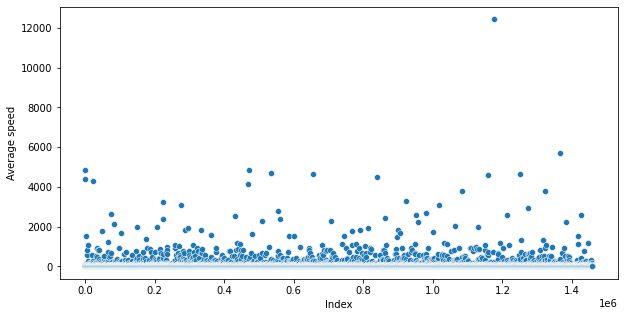

In [48]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Удаление выбросов
Найдем поездки, длительность которых превышает 24 часа, посчитаем их и удалим из набора данных.

In [49]:
mask_duration = taxi_data['trip_duration'] > 24*60*60
dura_otl = taxi_data[mask_duration]['id'].count()
print(f'Количество выбросов по признаку длительности поездки: {dura_otl}')
taxi_data.drop(taxi_data[mask_duration].index, axis = 0, inplace = True)

Количество выбросов по признаку длительности поездки: 4



Найдём поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

In [50]:
taxi_data['speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
mask_speed = taxi_data['speed'] > 300
speed_otl = taxi_data[mask_speed]['id'].count()
print(f'Количество выбросов по признаку длительности поездки: {speed_otl}')
taxi_data.drop(taxi_data[mask_speed].index, axis = 0, inplace = True)
taxi_data.drop(columns = ['speed'], axis = 1, inplace = True)

Количество выбросов по признаку длительности поездки: 407


###Удаление лишних столбцов

In [51]:
taxi_data[['trip_duration','haversine_distance']].describe().T

,count,mean,std,min,25%,50%,75%,max
trip_duration,1458233.0,953.074072,3171.726622,1.0,397.00000,663.000000,1075.000000,86392.000000
haversine_distance,1458233.0,3.439292,4.064528,0.0,1.23241,2.094297,3.876099,574.875442


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими исследование. 

Начинаем с целевого признака.   
Забегая вперед, скажу, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе.   
В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [52]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)


Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).   
Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

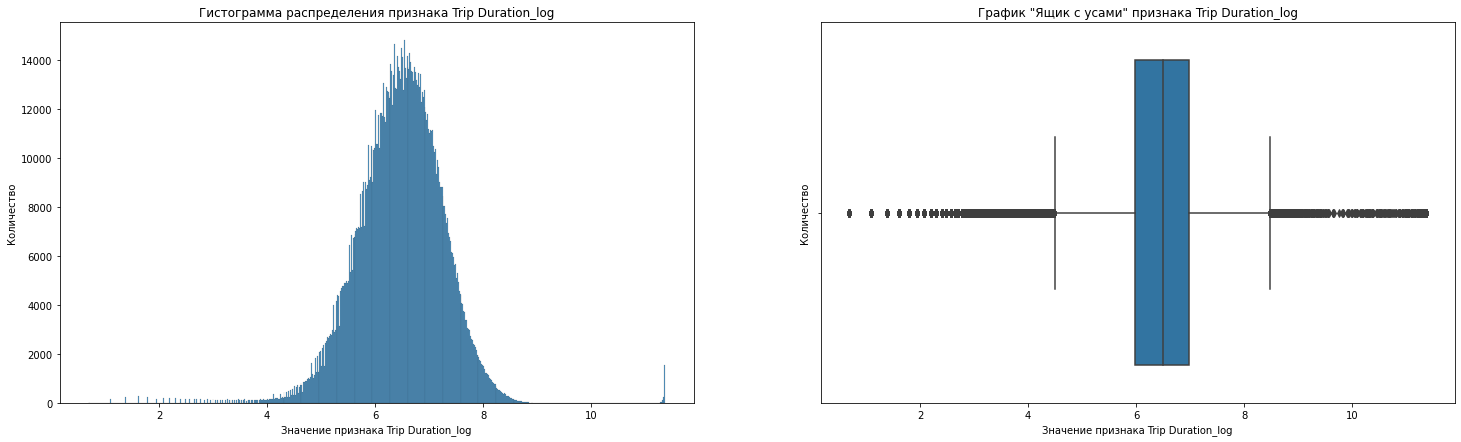

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=axes[0])
histplot.set_title('Гистограмма распределения признака Trip Duration_log');
histplot.set_xlabel('Значение признака Trip Duration_log') # название оси абсцисс;
histplot.set_ylabel('Количество') # название оси ординат;

boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', ax=axes[1])
boxplot.set_xlabel('Значение признака Trip Duration_log') # название оси абсцисс;
boxplot.set_ylabel('Количество') # название оси ординат;
boxplot.set_title('График "Ящик с усами" признака Trip Duration_log');

На первый взгляд распределение нормальное.  
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

In [54]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
#установим уровень значимости
alpha = 0.05

In [55]:
stat, p = normaltest(taxi_data['trip_duration_log'])
# normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p-value = %.2f' % (p))

# Интерпретация

if p > alpha/2:
    print(H0)
else:
    print(Ha)

p-value = 0.00
Данные не распределены нормально (мы отвергаем H0)


*Вопреки первоначальному выводу данные не распределены нормально.*

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

In [56]:
mask1 = taxi_data['vendor_id'] == 1
mask2 = taxi_data['vendor_id'] == 2
data1 = taxi_data[mask1]['trip_duration_log']
data2 = taxi_data[mask2]['trip_duration_log']

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


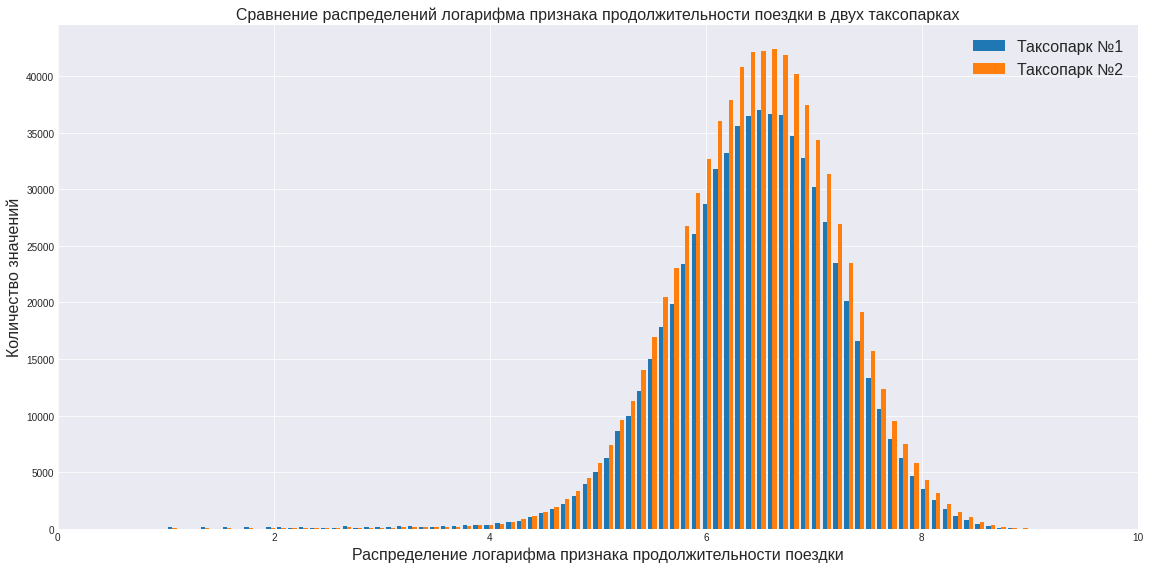

In [57]:
plt.style.use('seaborn-darkgrid');
bins = np.linspace(0, 10, 100)
fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist([data1, data2], bins, label=['Таксопарк №1', 'Таксопарк №2']);
plt.xlim(0,10);
# заголовок диаграммы
axes.set_title('Сравнение распределений логарифма признака продолжительности поездки в двух таксопарках', fontsize = 16) 
# название оси абсцисс;
axes.set_xlabel('Распределение логарифма признака продолжительности поездки', fontsize = 16)
# название оси ординат; 
axes.set_ylabel('Количество значений', fontsize = 16) 
axes.legend(loc='upper right',fontsize = 16);
fig.show();

Распределения в группах практически не отличаются, а значит признак vendor_id не имеет значения при определении длительности поездки.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).   
Сравним два распределения между собой.

In [58]:
taxi_data['store_and_fwd_flag'].value_counts()

N    1450192
Y       8041
Name: store_and_fwd_flag, dtype: int64

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


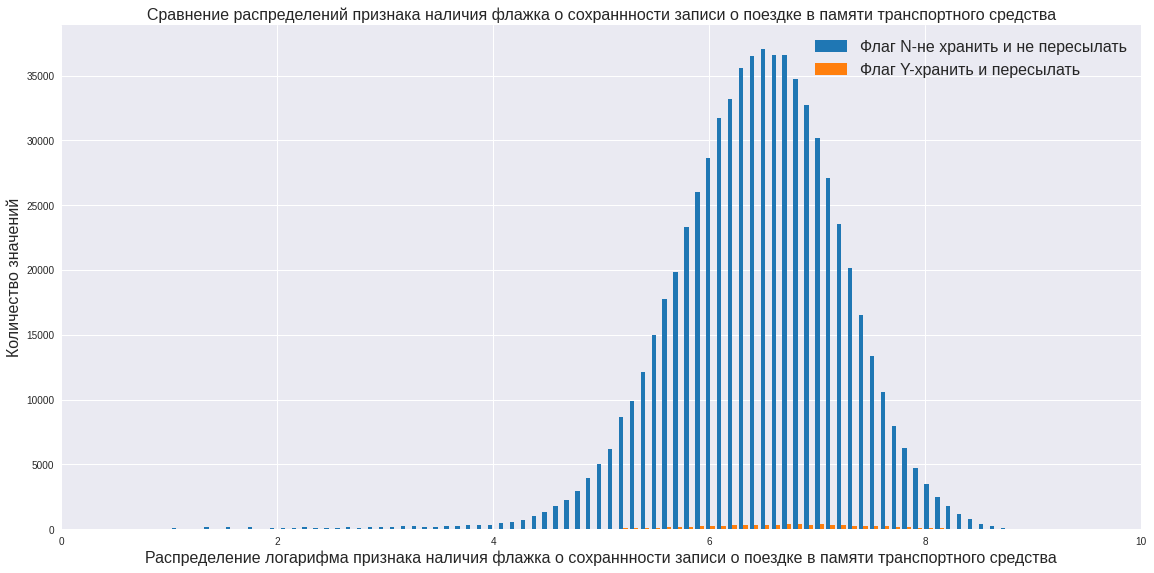

In [59]:
nask1 = taxi_data['store_and_fwd_flag'] == 'N'
mask2 = taxi_data['store_and_fwd_flag'] == 'Y'
data1 = taxi_data[mask1]['trip_duration_log']
data2 = taxi_data[mask2]['trip_duration_log']

plt.style.use('seaborn-notebook');
fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist([data1, data2], bins, label=['Флаг N-не хранить и не пересылать', 'Флаг Y-хранить и пересылать']);
plt.xlim(0,10);
# заголовок диаграммы
axes.set_title('Сравнение распределений признака наличия флажка о сохраннности записи о поездке в памяти транспортного средства', fontsize = 16) 
# название оси абсцисс;
axes.set_xlabel('Распределение логарифма признака наличия флажка о сохраннности записи о поездке в памяти транспортного средства', fontsize = 16)
# название оси ординат; 
axes.set_ylabel('Количество значений', fontsize = 16) 
axes.legend(loc='upper right',fontsize = 16);
fig.show();

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.  
 Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку).  
  Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответим на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [60]:
dataset_trip_count = taxi_data.groupby('pickup_hour')['id'].count()
dataset_trip_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median()

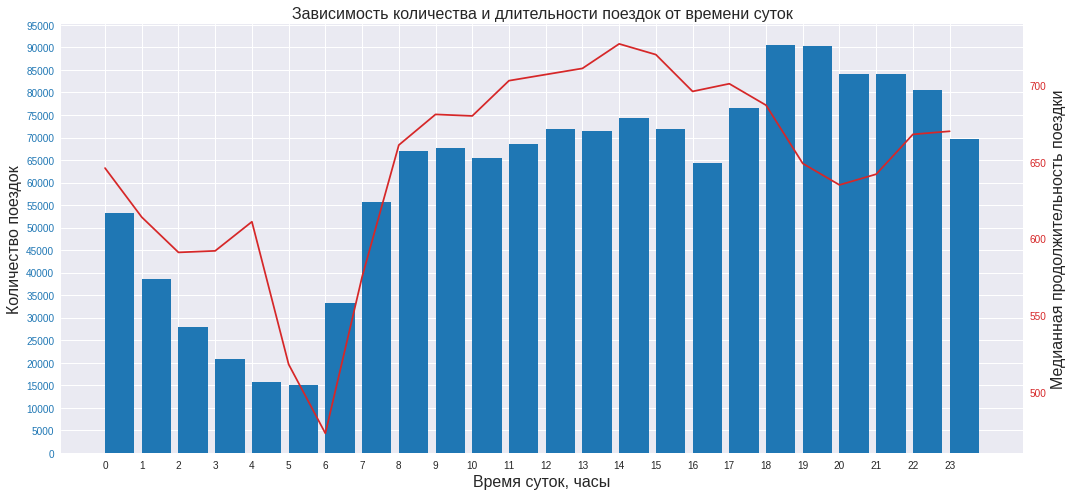

In [61]:
data1 = dataset_trip_count
data2 = dataset_trip_duration
x = np.arange(len(dataset_trip_count))
width = 0.8  #ширина столбика

fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.bar(x + width/2, dataset_trip_count, width, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Количество поездок',fontsize = 16)
ax1.set_xlabel('Время суток, часы',fontsize = 16)
ax1.set_title('Зависимость количества и длительности поездок от времени суток',fontsize = 16)
ax1.set_xticks(range(0, 24))
ax1.set_yticks(range(0, 100000, 5000));

# создадим экземпляр второй оси, который разделяет одну и ту же ось x
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.grid() 
ax2.set_xlabel('Время суток, часы',fontsize = 16)
ax2.set_ylabel('Медианная продолжительность поездки',fontsize = 16)
ax2.plot(dataset_trip_duration,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  #в противном случае правая метка Y будет слегка обрезана
plt.show()

*Выводы:   
а)Реже всего такси заказывали в 5 часов утра.  
б)Пик медианной продолжительности поездок приходился на 14 часов.*


Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
* Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответим на следующие вопросы:  

а) В какой день недели совершается больше всего поездок?  

б) В какой день недели медианная длительность поездок наименьшая?


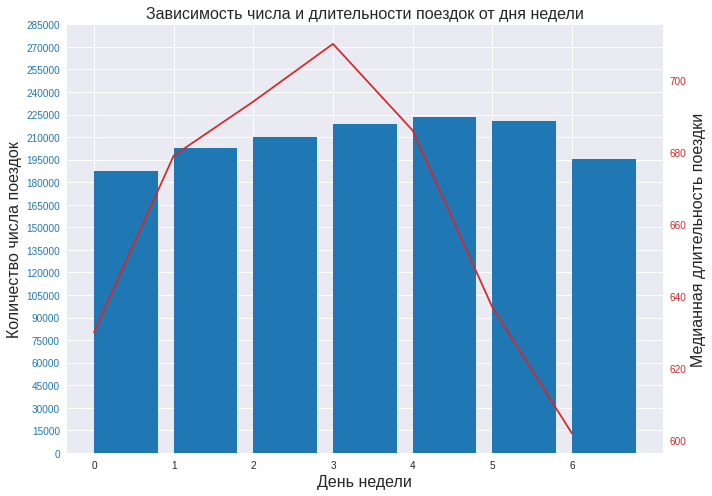

In [62]:
# ваш код здесь
dataset_trip_count = taxi_data.groupby('pickup_day_of_week')['id'].count()
dataset_trip_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

# Создадим датасеты для визуализации
data1 = dataset_trip_count
data2 = dataset_trip_duration
x = np.arange(len(dataset_trip_count))
width = 0.8  # ширина столбиков

fig, ax1 = plt.subplots(figsize=(10, 7))

color = 'tab:blue'
ax1.bar(x + width/2, dataset_trip_count, width, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Количество числа поездок',fontsize = 16)
ax1.set_xlabel('День недели',fontsize = 16)
ax1.set_title('Зависимость числа и длительности поездок от дня недели',fontsize = 16)
ax1.set_xticks(range(0, 7))
ax1.set_yticks(range(0, 300000, 15000));

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.grid() 
ax2.set_xlabel('День недели',fontsize = 16)
ax2.set_ylabel('Медианная длительность поездки',fontsize = 16)
ax2.plot(dataset_trip_duration,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

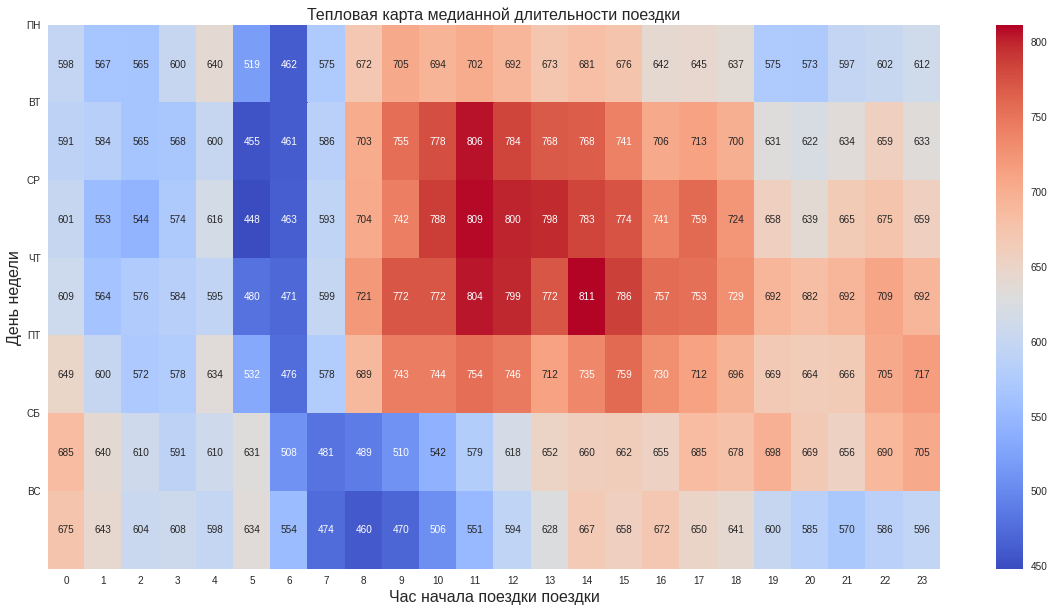

In [63]:
plt.figure(figsize=(20, 10));
pivot = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_day_of_week',
    columns='pickup_hour',
    aggfunc = 'median',
)
heatmap = sns.heatmap(data=pivot, cmap='coolwarm',annot = True, fmt='0.0f');
heatmap.set_title('Тепловая карта медианной длительности поездки', fontsize=16);
heatmap.set_xlabel('Час начала поездки поездки', fontsize=16) 
heatmap.set_ylabel('День недели', fontsize=16) 
order_dow = ['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']
plt.yticks(range(0,7), order_dow, rotation = 'horizontal');

*Выводы: Максимальные медианные продолжительности поездок начинались в четверг в 14.00.   
Минимальные медианные по продолжительности поездки начинались в среду в 5 утра.*

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

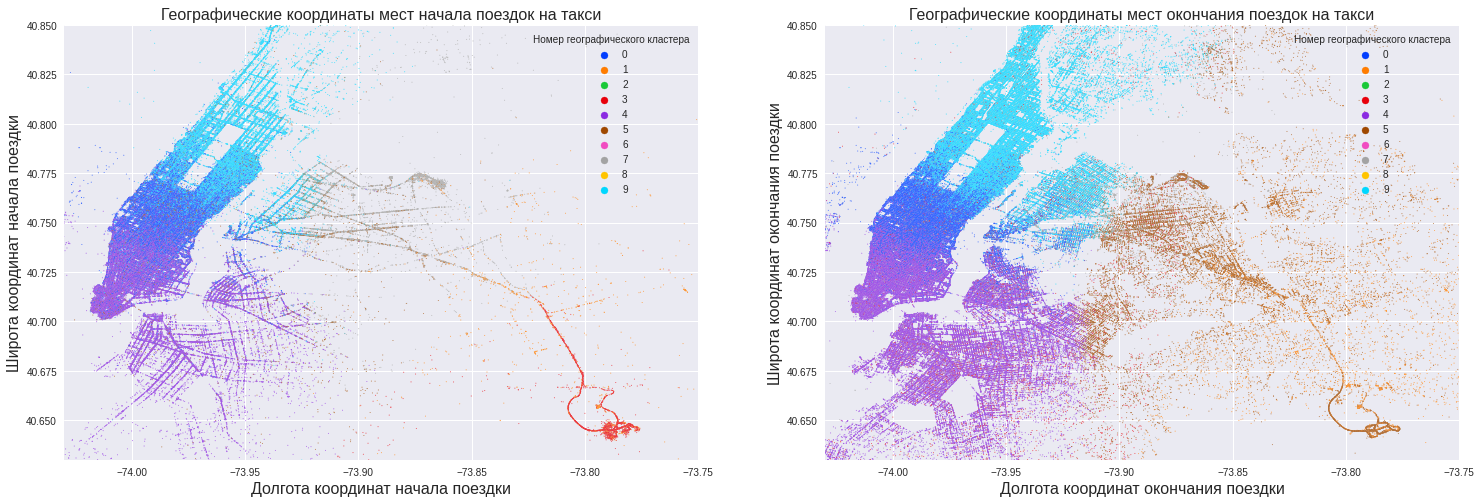

In [64]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

a = sns.scatterplot(x='pickup_longitude', 
                    y='pickup_latitude', 
                    data=taxi_data, 
                    hue='geo_cluster', 
                    legend=True, 
                    palette="bright", 
                    s=1, 
                    alpha=.8,
                    ax = ax[0]
                    )
#a.set_theme(font_scale = 16, xlabel=', ylabel='',title='')
a.set_title('Географические координаты мест начала поездок на такси', fontsize=16);
a.set_xlabel('Долгота координат начала поездки', fontsize=16) 
a.set_ylabel('Широта координат начала поездки', fontsize=16)
a.legend(loc='upper right', title='Номер географического кластера')


a.set_xlim(-74.03, -73.75)
a.set_ylim(40.63, 40.85)

b = sns.scatterplot(x='dropoff_longitude',
                    y='dropoff_latitude', 
                    data=taxi_data, 
                    hue='geo_cluster', 
                    legend=True, 
                    palette="bright", 
                    s=1, 
                    alpha=.8,
                    ax = ax[1]
                    )
b.set_xlim(-74.03, -73.75)
b.set_ylim(40.63, 40.85)

plt.legend(loc='upper right', title='Номер географического кластера')
plt.xlabel('Долгота координат окончания поездки', fontsize = 16)
plt.ylabel('Широта координат окончания поездки', fontsize = 16)
plt.title('Географические координаты мест окончания поездок на такси', fontsize = 16)

plt.show();

*Выводы: Такси чаще начинает движение в деловой части города и заканчивает в жилых районах. Из международного аэропорта JFK чаще выезжают на такси, чем приезжают*

Определим количество кластеров, не вошедших на графики

In [65]:
taxi_data_test = taxi_data[['pickup_longitude','pickup_latitude','geo_cluster']]
mask1 = taxi_data_test['pickup_longitude'] >= -74.03
mask2 = taxi_data_test['pickup_longitude'] <= -73.75
mask3 = taxi_data_test['pickup_latitude'] >= 40.63
mask4 = taxi_data_test['pickup_latitude'] <= 40.85
print(f'Количество кластеров на графике начала движения: {len(taxi_data_test[mask1 & mask2 & mask3 & mask4]["geo_cluster"].unique())} из 10')

Количество кластеров на графике начала движения: 8 из 10


In [66]:
df_trip_test1 = taxi_data[['dropoff_longitude','dropoff_latitude','geo_cluster']]
mask1 = df_trip_test1['dropoff_longitude'] >= -74.03 
mask2 = df_trip_test1['dropoff_longitude'] <= -73.75
mask3 = df_trip_test1['dropoff_latitude'] >= 40.63 
mask4 = df_trip_test1['dropoff_latitude'] <= 40.85
print(f'Количество кластеров на графике окончания движения: {len(df_trip_test1[mask1 & mask2 & mask3 & mask4]["geo_cluster"].unique())} из 10')

Количество кластеров на графике окончания движения: 7 из 10


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [67]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


### Удаление неинформативных и избыточных признаков 

a) Признак id является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности.

б) **Утечка данных** (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.
Для нас это время окончания поездки, dropoff_datetime

Исключим выбранные в пунктах а) и в) признаки из исходной таблицы с данными.

In [68]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime']
taxi_data = taxi_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(taxi_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [69]:
drop_columns = ['pickup_datetime', 'pickup_date']
taxi_data = taxi_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(taxi_data.shape))

Shape of data:  (1458233, 23)


Теперь займёмся кодированием категориальных признаков.   
В наших данных к категориальным можно отнести следующие признаки:
* vendor_id;
* store_and_fwd_flag;
* pickup_day_of_week;
* geo_cluster;
* events.  

Первые два (vendor_id и store_and_fwd_flag) из них являются бинарными (имеют два уникальных значения).   
Давайте их закодируем ↓

### Кодирование бинарных признаков

a) Закодируем признак vendor_id в таблице taxi_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 0, и 1 в противном случае.  
Рассчитаем среднее по закодированному столбцу vendor_id с точностью до сотых.

б) Закодируем признак store_and_fwd_flag в таблице taxi_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.   
Рассчитаем среднее по закодированному столбцу store_and_fwd_flag с точностью до тысячных.



In [70]:
taxi_data['vendor_id'] = taxi_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
taxi_data['store_and_fwd_flag'] = taxi_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('Cреднее по закодированному столбцу vendor_id: {:.2f}'.format(taxi_data['vendor_id'].mean()))
print('Cреднее по закодированному столбцу store_and_fwd_flag: {:.3f}'.format(taxi_data['store_and_fwd_flag'].mean()))

Cреднее по закодированному столбцу vendor_id: 0.53
Cреднее по закодированному столбцу store_and_fwd_flag: 0.006


### Однократное кодирование OneHotEncoding

Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице taxi_data с помощью OneHotEndoder() из библиотеки sklearn.   
Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

In [71]:
columns_to_change = ['pickup_day_of_week','geo_cluster','events']
# Создание датафрейма
data_onehot = taxi_data[columns_to_change]
# Создание экземпляра класса OneHotEncoder()
one_hot_encoder = OneHotEncoder(drop = 'first')
# Кодирование признака
ohe_res = one_hot_encoder.fit_transform(data_onehot[columns_to_change])
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
ohe_df = pd.DataFrame(ohe_res.toarray(), columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [72]:
taxi_data = pd.concat([taxi_data.reset_index(drop=True).drop(columns_to_change, axis=1), ohe_df], axis=1)
print('Shape of data: {}'.format(taxi_data.shape))

Shape of data: (1458233, 38)


Таблица увеличилась на 15 столбцов


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log.   
В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [73]:
X = taxi_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = taxi_data['trip_duration']
y_log = taxi_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей.   
Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать hold-out-валидацию.   
Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и времязатратным.

Разобьём выборку на обучающую и валидационную в соотношении 67/33:



In [74]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Отбор признаков
С помощью метода SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.   
Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

In [75]:
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

SelectKBest(k=25, score_func=<function f_regression at 0x7f20606f1200>)

In [76]:
#подготовим список признаков для построения модели логистической регрессии
list_SelectKBest = list(selector.get_feature_names_out())

In [77]:
X_train = X_train[list_SelectKBest]
X_valid = X_valid[list_SelectKBest]

In [71]:
X_train.shape

(977016, 25)

In [72]:
X_valid.shape

(481217, 25)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Нормализация данных
Нормализуем предикторы в обучающей и валидационной выборках с помощью метода MinMaxScaler из библиотеки sklearn. 
Обучение нормализатора произведём на обучающей выборке, а трансформацию на обучающей и валидационной!

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлим до сотых.


In [73]:
# Создание экземпляра класса MinMaxScaler(), диапазон {0,1}
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# Масштабирование признака
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_valid_scaled = minmax_scaler.transform(X_valid)

In [74]:
pd.DataFrame(X_train_scaled).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_train_scaled.csv', sep = ',', index = False)
pd.DataFrame(X_valid_scaled).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_valid_scaled.csv', sep = ',', index = False)

In [74]:
X_valid_scaled.mean().round(2)

0.26

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Что такое среднеквадратическая логарифмическая ошибка?
Среднеквадратическая логарифмическая ошибка (MSLE) может быть интерпретирована как мера отношения между истинными и предсказанными значениями. Среднеквадратическая логарифмическая ошибка, как следует из названия, является разновидностью среднеквадратичной ошибки. MSLE заботит только процентная разница.

### 1. Модель линейной регрессии LinearRegression()
Построим модель линейной регрессии на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе).     
Все параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [75]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)
 
y_train_predicted = model.predict(X_train_scaled)
y_valid_predicted = model.predict(X_valid_scaled)

rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predicted))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predicted))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.54
RMSLE_valid: 0.54


### 2. Модель полиномиальной регрессии 2-ой степени PolynomialFeatures()
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn.  
Параметр include_bias выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Наблюдаются ли у нашей модели признаки переобучения?


In [76]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(include_bias=False)
#poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки

X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled) 
#Генерируем полиномиальные признаки для тестовой выборки

#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_valid_poly.shape)

(977016, 350)
(481217, 350)


In [78]:
pd.DataFrame(X_train_poly).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_train_poly.csv', sep = ',', index = False)
pd.DataFrame(X_valid_poly).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_valid_poly.csv', sep = ',', index = False)
pd.DataFrame(y_train_log).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_train_log.csv', sep = ',', index = False)
pd.DataFrame(y_valid_log).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_valid_log.csv', sep = ',', index = False)

In [4]:
X_train_poly = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_train_poly.csv')
X_valid_poly = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_valid_poly.csv')
y_train_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_train_log.csv')
y_valid_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_valid_log.csv')

In [ ]:
#X_train_poly.drop(X_train_poly.columns[[0]], axis = 1, inplace = True)
#X_valid_poly.drop(X_valid_poly.columns[[0]], axis = 1, inplace = True)
#y_train_log.drop(y_train_log.columns[[0]], axis = 1, inplace = True)
#y_valid_log.drop(y_valid_log.columns[[0]], axis = 1, inplace = True)

In [9]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predict_poly))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predict_poly))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.47
RMSLE_valid: 0.70


### 3. Модель полиномиальной регрессии 2-ой степени с L2-регуляризацией Ridge()
Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы нормализованы, целевая переменная используется в логарифмическом масштабе). Коэффициент регуляризации $\alpha устанавливаем равным 1, остальные параметры оставляем по умолчанию.

Для полученной модели рассчитайтаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [10]:
# ваш код здесь
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Обучаем модель
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = ridge_lr_poly.predict(X_valid_poly)

rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predict_poly))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predict_poly))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.48
RMSLE_valid: 0.48


### 4. Модель дерева решений DecisionTreeRegressor()
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставляем по умолчанию. 

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Наблюдаются ли у модели признаки переобучения?


In [75]:
regr1 = DecisionTreeRegressor()
regr1.fit(X_train_scaled, y_train_log)

y_train_pred = regr1.predict(X_train_scaled)
y_valid_pred = regr1.predict(X_valid_scaled)
  
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.00
RMSLE_valid: 0.56


Метрика RMSLE на тренировочной выборке равна 0, а на валидационной 0.56, это признак переобучения, модель полностью "подстроилась" под тренировочный датасет, а на валидационном выдала ошибки.

### Подбор гиперпараметров модели дерева решений.

Переберём все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлим до сотых.


In [6]:
X_train_scaled = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_train_scaled.csv')
X_valid_scaled = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/X_valid_scaled.csv')
y_train_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_train_log.csv')
y_valid_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/y_valid_log.csv')

In [79]:
numbers = np.zeros((13, 3))

header = ['depth_step', 'rmsle_train', 'rmsle_valid']

data_rmsle = pd.DataFrame(data = numbers, columns = header)

row = 0
for depth_step in range(7, 20):
  regr1 = DecisionTreeRegressor(max_depth = depth_step)
  regr1.fit(X_train_scaled, y_train_log)
  
  y_train_pred = regr1.predict(X_train_scaled)
  y_valid_pred = regr1.predict(X_valid_scaled)
    
  rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred))
  rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred))
  data_rmsle.loc[row,'rmsle_train'] = rmsle_train
  data_rmsle.loc[row,'rmsle_valid'] = rmsle_valid
  data_rmsle.loc[row,'depth_step'] = depth_step
  row+=1

data_rmsle.set_index(['depth_step'], inplace=True)

In [96]:
data_rmsle.iloc[0][0].round(2)

0.44

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


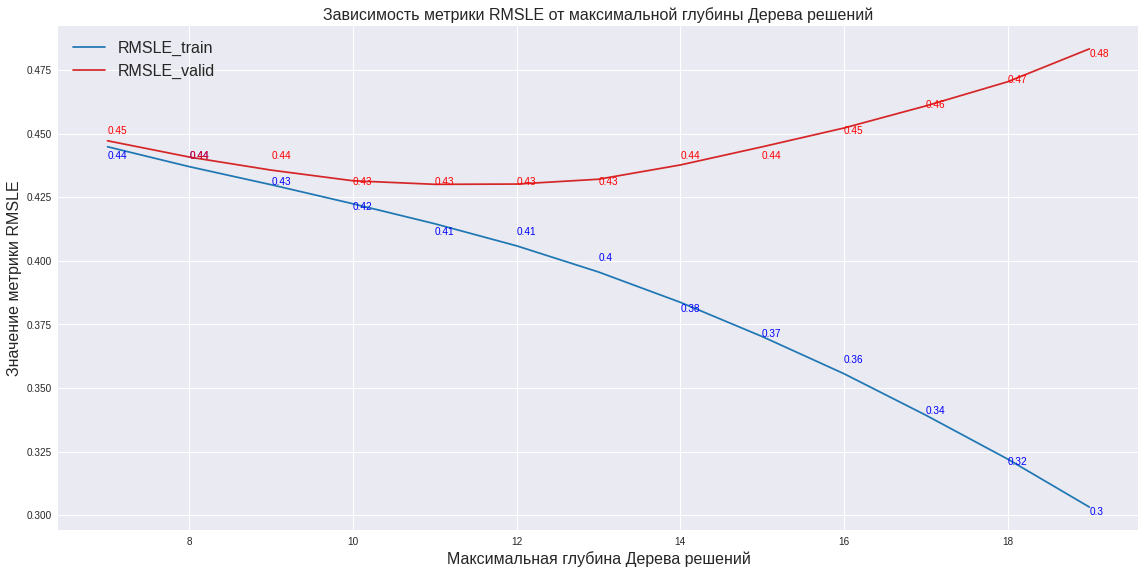

In [99]:
#составим график изменения метрик в зависимости от глубины дерева
data1 = data_rmsle[['rmsle_train']]
data2 = data_rmsle[['rmsle_valid']]

fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0, 0, 1, 1])

color = 'tab:blue'
axes.plot(data1, color=color)
color = 'tab:red'
axes.plot(data2,color=color)
axes.set_ylabel('Значение метрики RMSLE',fontsize = 16)
axes.set_xlabel('Максимальная глубина Дерева решений',fontsize = 16)
axes.set_title('Зависимость метрики RMSLE от максимальной глубины Дерева решений', fontsize = 16)
axes.legend(['RMSLE_train', 'RMSLE_valid'], fontsize = 16)
for i in range(len(data1)):
  plt.text (data_rmsle.index[i], data_rmsle.iloc[i][0].round(2), data_rmsle.iloc[i][0].round(2),color='blue')
  plt.text (data_rmsle.index[i], data_rmsle.iloc[i][1].round(2), data_rmsle.iloc[i][1].round(2),color='red')
fig.tight_layout()
plt.show()

Оптимальное значение максимальной глубины дерева, при которой наблюдается минимальное значение RMSLE на обучающей выборке, но при этом ещё не  наблюдается переобучение (валидационная кривая ещё не начинает возрастать) равно 12.   
Значение метрик в этой точке:  

RMSLE_train: 0.41  

RMSLE_valid: 0.43

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### 5. Модель случайного леса RandomForestRegressor()

Построим модель случайного леса на обучающей выборке (факторы нормализованы, целевая переменная используется в логарифмическом масштабе). 
В качестве гиперпараметров укажем следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [100]:
regr_rf = RandomForestRegressor(max_depth=12, n_estimators=200, min_samples_split=20, criterion='squared_error', verbose = True, random_state=42)
regr_rf.fit(X_train_scaled, y_train_log)
 
y_train_pred_rf = regr_rf.predict(X_train_scaled)
y_valid_pred_rf = regr_rf.predict(X_valid_scaled)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred_rf))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred_rf))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 36.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE_train: 0.40
RMSLE_valid: 0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.0s finished


### 6. Модель градиентного бустинга над деревьями решений GradientBoostingRegressor()
Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров указывем следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [7]:
gb = GradientBoostingRegressor(
    learning_rate=0.5,
	  max_depth=6, #максимальная глубина дерева
    n_estimators=100, #количество деревьев
    min_samples_split=30,
    random_state=42 #генератор случайных чисел
  )
gb.fit(X_train_scaled, y_train_log)
 
y_train_pred_gb = gb.predict(X_train_scaled)
y_valid_pred_gb = gb.predict(X_valid_scaled)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred_gb))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred_gb))

print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSLE_train: 0.37
RMSLE_valid: 0.39


Наилучший результат, т.е наименьшее значение RMSLE на валидационной выборке, показала модель Градиентный бустинг над деревьями решений


###Визуализация значимости признаков
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


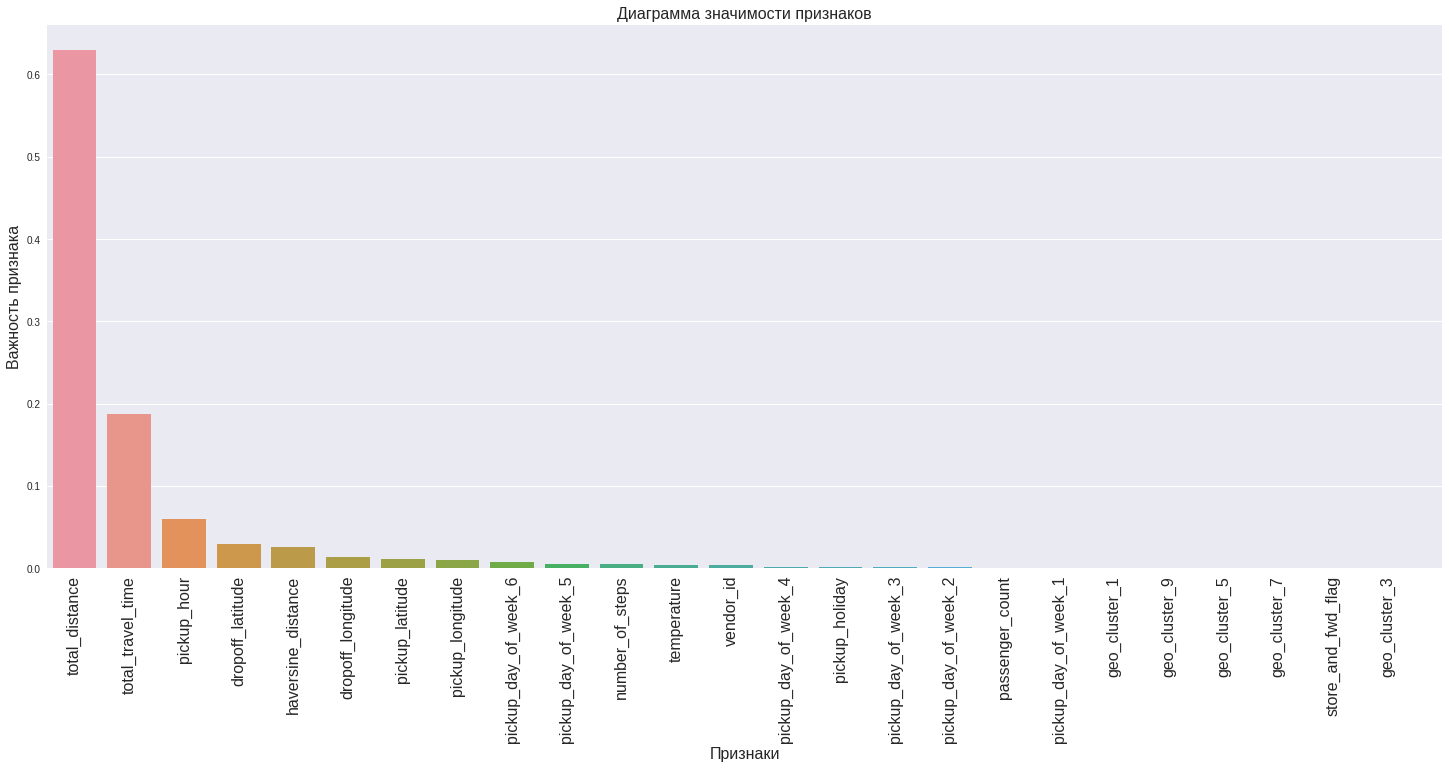

In [79]:
fig, ax = plt.subplots(figsize=(25, 10)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
data_set = pd.DataFrame(data =[feature, feature_importances]).T
data_set.sort_values(by = 1, ascending = False, inplace = True)
#Строим столбчатую диаграмму
sns.barplot(x=data_set[0], y=data_set[1], ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Диаграмма значимости признаков', fontsize = 16)
ax.set_xlabel('Признаки', fontsize = 16)
plt.xticks(range(0,26), data_set[0], rotation = 'vertical',fontsize = 16) ;
ax.set_ylabel('Важность признака', fontsize = 16);


### Финальный расчет метрики MeAE
Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведём в минуты и округлим до десятых.


In [ ]:
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(y_valid_pred_gb) - 1
meae_valid_min = median_absolute_error(y_valid, y_valid_pred)/60

print('MeAE_valid: {:.1f}'.format(meae_valid_min))

MeAE_valid: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/Project5_test_data.zip")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/Project5_osrm_data_test.zip")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)

In [ ]:
#test_data = add_geographical_features(test_data)

In [ ]:
#pd.DataFrame(test_data).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/test_data.csv', sep = ',')

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/test_data.csv')

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           625134 non-null  int64  
 1   id                                   625134 non-null  object 
 2   vendor_id                            625134 non-null  int64  
 3   pickup_datetime                      625134 non-null  object 
 4   passenger_count                      625134 non-null  int64  
 5   pickup_longitude                     625134 non-null  float64
 6   pickup_latitude                      625134 non-null  float64
 7   dropoff_longitude                    625134 non-null  float64
 8   dropoff_latitude                     625134 non-null  float64
 9   store_and_fwd_flag                   625134 non-null  object 
 10  pickup_date                          625134 non-null  object 
 11  pickup_hour  

In [ ]:
test_data.drop(test_data.columns[[0,17]], axis = 1, inplace = True)

In [ ]:
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)

In [ ]:
test_data = fill_null_weather_data(test_data)

In [ ]:
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

In [ ]:
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

Shape of data: (625134, 25)


In [ ]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
test_data = test_data.drop(drop_columns, axis=1)

In [ ]:
X_test = test_data[list_SelectKBest]
X_test_scaled = minmax_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [ ]:
y_test_pred_gb = gb.predict(X_test_scaled)

После выполнения всех этих шагов сделаем предсказание длительности поездки для тестовой выборки. Переведём предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

In [ ]:
y_test_predict = np.exp(y_test_pred_gb) - 1

После того, как сформированы предсказания длительности поездок на тестовой выборке создадим submission-файл в формате csv, отправим его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:

In [ ]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/submission_gb.csv', index=False)

### 7. Модель экстремального градиентного бустинга XGBoost

В завершение по ансамблевым моделям попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования для начала установим пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
#import xgboost as xgb

Перед обучением модели переведём наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=list_SelectKBest)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=list_SelectKBest)
dtest = xgb.DMatrix(X_test_scaled, feature_names=list_SelectKBest)

Обучение модели XGBoost происходит с помощью метода train, в который передадим параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42228	valid-rmse:5.42188
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:1.93568	valid-rmse:1.93565
[20]	train-rmse:0.785057	valid-rmse:0.78601
[30]	train-rmse:0.47891	valid-rmse:0.481079
[40]	train-rmse:0.421415	valid-rmse:0.424272
[50]	train-rmse:0.409768	valid-rmse:0.413082
[60]	train-rmse:0.404627	valid-rmse:0.408336
[70]	train-rmse:0.401096	valid-rmse:0.405208
[80]	train-rmse:0.398925	valid-rmse:0.40334
[90]	train-rmse:0.397165	valid-rmse:0.401898
[100]	train-rmse:0.395485	valid-rmse:0.400554
[110]	train-rmse:0.394275	valid-rmse:0.399562
[120]	train-rmse:0.393263	valid-rmse:0.398871
[130]	train-rmse:0.392228	valid-rmse:0.398092
[140]	train-rmse:0.391054	valid-rmse:0.397375
[150]	train-rmse:0.390064	valid-rmse:0.396831
[160]	train-rmse:0.389417	valid-rmse:0.396358
[170]	train-rmse:0.388484	valid-rmse:0.395757
[180]	train-rmse:0.387527	valid-rmse:0.395144

Предсказажем целевой признак на новых данных с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39132


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


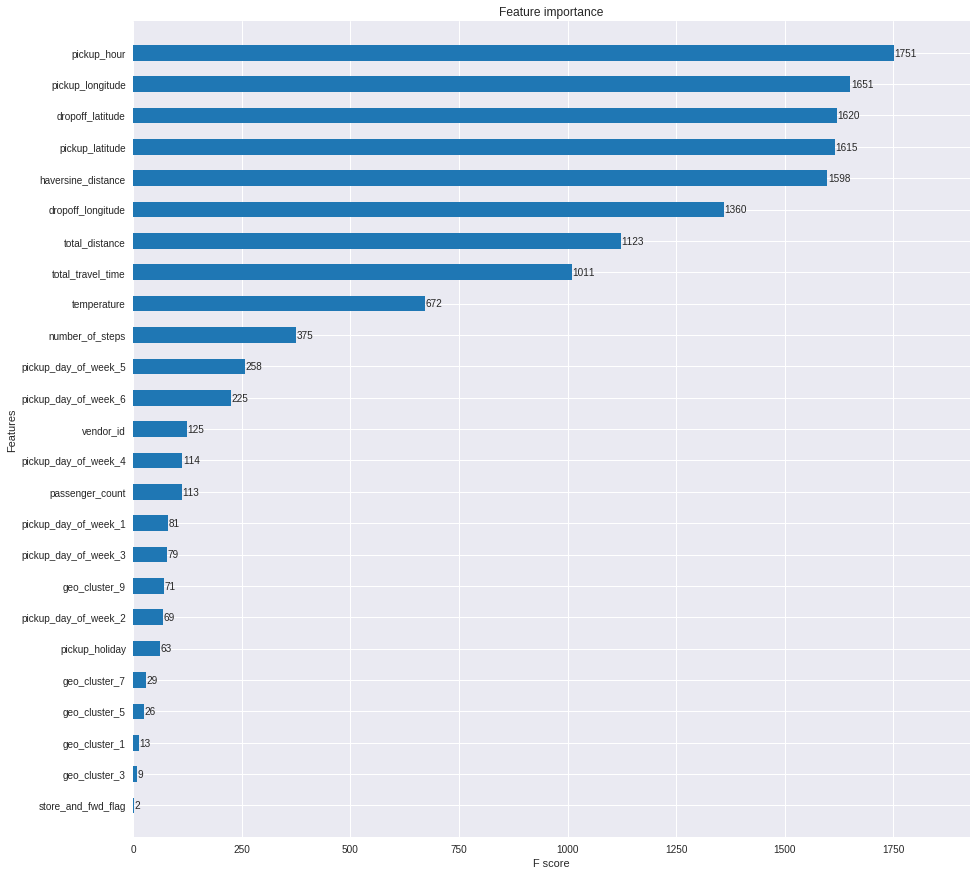

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

##7.Подведение итогов

В результате исследования данных получены следующие 
результаты:  
1. Модель линейной регрессии LinearRegression()  
    RMSLE_train: 0.54  
    RMSLE_valid: 0.54  
2. Модель полиномиальной регрессии 2-ой степени PolynomialFeatures()    
    RMSLE_train: 0.47  
    RMSLE_valid: 0.70  
3. Модель полиномиальной регрессии 2-ой степени с L2-регуляризацией Ridge()  
    RMSLE_train: 0.48  
    RMSLE_valid: 0.48 
4. Модель дерева решений DecisionTreeRegressor()  
    RMSLE_train: 0.00  
    RMSLE_valid: 0.56  
5. Модель случайного леса RandomForestRegressor()  
    RMSLE_train: 0.40  
    RMSLE_valid: 0.41  
6. Модель градиентного бустинга над деревьями решений GradientBoostingRegressor()  
    RMSLE_train: 0.37  
    RMSLE_valid: 0.39  
7. Модель экстремального градиентного бустинга XGBoost  
    Modeling RMSLE 0.39132

Наилучший результат, т.е наименьшее значение RMSLE на валидационной выборке, показала модель Градиентный бустинг над деревьями решений.